## YouTube Trending Video Analysis & Prediction

### Joel Day, Caleb McCurdy, & Lane Whitmore

### The University of San Diego

#### ADS 508 - Data Science Cloud Computing

In [1]:
# General imports
import pandas as pd
import numpy as np

# nlp processing imports
import string
import re
import nltk

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Sagemaker imports
import sagemaker
# from sagemaker.sklearn.processing import 
from sagemaker import get_execution_role
from sklearn.feature_extraction.text import CountVectorizer

# athena connection imports
!pip install pyathena
from pyathena import connect
import boto3

## Establishing Athena for SQL Queries

In [2]:
region = boto3.Session().region_name
role = get_execution_role()

In [3]:
# Set Athena for data wrangling // exploration
session = sagemaker.Session()

bucket = "ads508youtubebucket"

In [4]:
ingest_create_athena_db_passed = False

db_name = "youtubedb"

In [5]:
# temp query storage
s3_athena = "s3://ads508youtubebucket/athena/tmp/"

# file storage
youtube_dir = "s3://ads508youtubebucket/athena/files/"

# creating connection to database
conn = connect(region_name=region, s3_staging_dir=s3_athena)

### Creating Database

In [6]:
# Creating DATABASE with db_name above
create_db = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)

pd.read_sql(create_db, conn)

""


### Creating Tables

#### CSV Tables

Currently, the tables below are still struggling to appropriately populate the tables. If the data type is anything but strings, the column becomes null for all values and the comma seperation is not consistent.

In [7]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.ca_csv", conn)


ca_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.ca_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://ads508youtubebucket/youtubeStatistics/csv/can/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(ca_csv_create, conn)

""


In [8]:
pd.read_sql(f"SELECT * FROM {db_name}.ca_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,d1HUFPBWUh4,"Nous servons dans la cantine d'un lycée, les é...",2022-06-19T08:03:37Z,UCtxhwJ-6n4_C6ElALThD25Q,Mcfly et Carlito la chaîne secondaire,22,2022-06-21T00:00:00Z,[None],1684938,122259,0,1934,https://i.ytimg.com/vi/d1HUFPBWUh4/default.jpg,False,False,Après avoir perdu face à Maxime Gasteuil dans ...
1,DPJL488cfRw,Yunchan Lim 임윤찬 – RACHMANINOV Piano Concerto N...,2022-06-19T19:04:24Z,UC5Oz2fuXlILwEH4P96h2LLg,The Cliburn,10,2022-06-21T00:00:00Z,[None],1158892,36617,0,2125,https://i.ytimg.com/vi/DPJL488cfRw/default.jpg,False,False,"Final Round Concerto IIJune 17, 2022Bass Perfo..."
2,ASMMDYLry80,48hrs on Luxury Rocky Mountaineer Train - From...,2022-06-19T21:44:53Z,UC50xPFPma-nCS5GZpAFukpQ,Trek Trendy,19,2022-06-21T00:00:00Z,rocky mountaineer|rocky mountaineer train|luxu...,183186,7228,0,608,https://i.ytimg.com/vi/ASMMDYLry80/default.jpg,False,False,Head to https://squarespace.com/trektrendy to ...
3,Mbo4FzRy7k4,Everything in moderation! WHAT I EAT | Wellnes...,2022-06-20T04:48:12Z,UCAHufvd02viJSRdt3ojdPOg,Sarahs Day,22,2022-06-21T00:00:00Z,what I eat in a day|full day of eating|grocery...,178079,8414,0,331,https://i.ytimg.com/vi/Mbo4FzRy7k4/default.jpg,False,False,WELLNESS WEEK IS NOW LIVE!!https://www.sarahsd...
4,nEFcbKF4WfY,Return to Valoran City - Star Guardian 2022 | ...,2022-06-20T15:00:25Z,UC2t5bjwHdUX4vM2g8TRDq5g,League of Legends,20,2022-06-21T00:00:00Z,Star guardian|star guardian 2022|star guardian...,1000267,55422,0,3145,https://i.ytimg.com/vi/nEFcbKF4WfY/default.jpg,False,False,A new day is just over the horizon. Star Guard...
5,Ul_LSTpBVVA,Overpowered Weapons vs Custom Bosses in Minecraft,2022-06-19T15:30:03Z,UC_cvTMeip9po2hZdF3aBXrA,BeckBroJack,20,2022-06-21T00:00:00Z,minecraft|custom bosses|minecraft bosses|custo...,457641,38378,0,604,https://i.ytimg.com/vi/Ul_LSTpBVVA/default.jpg,False,False,Today I'm using Overpowered Weapons to beat Tw...
6,8kzU3gF92o0,ON DEVINE QUI EST SON MEC (Ft. Toomuchlucile &...,2022-06-19T15:30:01Z,UCXqnG7hbmGYDqC1iTNkVdew,Océane,22,2022-06-21T00:00:00Z,oceane|océane|océane les anges|oce.rthn|oce,729434,61449,0,2933,https://i.ytimg.com/vi/8kzU3gF92o0/default.jpg,False,False,"COUCOU GUYS!! Dans la vidéo d'aujourd'hui, on ..."
7,adBqwKLyZj4,I Completed The Wild Update Already..,2022-06-19T17:00:01Z,UCS5Oz6CHmeoF7vSad0qqXfw,DanTDM,20,2022-06-21T00:00:00Z,dantdm|dan tdm|gaming|video games|minecraft|funny,827033,45921,0,3312,https://i.ytimg.com/vi/adBqwKLyZj4/default.jpg,False,False,SUBSCRIBE OR THE WARDEN HUGS YOU TIGHTLYIn thi...
8,jQI5jD6ujXs,JEU EN VRAC - l'histoire de l'AMSTRAD,2022-06-19T16:00:32Z,UCCMxHHciWRBBouzk-PGzmtQ,Bazar du Grenier,20,2022-06-21T00:00:00Z,Jeu en vrac|jdg|joueur du grenier|bazar du gre...,604228,53875,0,1595,https://i.ytimg.com/vi/jQI5jD6ujXs/default.jpg,False,False,Cette vidéo est sponsorisée par Rhinoshield ! ...
9,D3qFfAEp9AU,Are They All The Same Motor Oil? Let's Settle ...,2022-06-19T16:49:32Z,UC2rzsm1Qi6N1X-wuOg_p0Ng,Project Farm,26,2022-06-21T00:00:00Z,project farm|motor oil review|are all motor oi...,533327,29212,0,4457,https://i.ytimg.com/vi/D3qFfAEp9AU/default.jpg,False,False,Let's find out if Pennzoil's motor oil (Pennzo...


In [9]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.us_csv", conn)


us_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.us_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ',', 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://ads508youtubebucket/youtubeStatistics/csv/usa/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(us_csv_create, conn)

""


In [10]:
pd.read_sql(f"SELECT * FROM {db_name}.us_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,X3dMeuHtDYg,"Minecraft, But I Can NEVER Leave This Square (#6)",2022-12-16T03:10:41Z,UCRlEFn0L2G_DktbyvN0AZ5A,WadZee,20,2022-12-22T00:00:00Z,Minecraft|WadZee|Hardcore|WadZee Hardcore|WadZ...,1941333,115982,0,14092,https://i.ytimg.com/vi/X3dMeuHtDYg/default.jpg,False,False,Today I played Minecraft but I can NEVER leave...
1,0dERKso3lys,MO3 & Tory Lanez - They Don't Know (Official V...,2022-12-16T05:00:22Z,UC_PQ7gGEKIwJv0YsnxH3dUw,HSM,10,2022-12-22T00:00:00Z,Mo3|Dallas|Texas|Rap Music|Badazz,940419,25621,0,1437,https://i.ytimg.com/vi/0dERKso3lys/default.jpg,False,False,Listen to the single “They Don't Know. Out Now...
2,0uQqMxXoNVs,It’s Time to Pay Attention to A.I. (ChatGPT an...,2022-12-16T04:25:56Z,UC4QZ_LsYcvcq7qOsOhpAX4A,ColdFusion,28,2022-12-22T00:00:00Z,Coldfusion|TV|Dagogo|Altraide|Technology|Apple...,1120302,47725,0,6693,https://i.ytimg.com/vi/0uQqMxXoNVs/default.jpg,False,False,Imagine being able to have a language conversa...
3,4s2ynUAJ5ZU,How Developments In Nuclear Fusion Change Ever...,2022-12-15T20:04:57Z,UCqoAEDirJPjEUFcF2FklnBA,StarTalk,28,2022-12-22T00:00:00Z,startalk|star talk|startalk radio|neil degrass...,1653505,60740,0,5794,https://i.ytimg.com/vi/4s2ynUAJ5ZU/default.jpg,False,False,What is thermonuclear fusion? Neil deGrasse Ty...
4,aeWyp2vXxqA,Black Hole Star – The Star That Shouldn't Exist,2022-12-15T15:00:12Z,UCsXVk37bltHxD1rDPwtNM8Q,Kurzgesagt – In a Nutshell,27,2022-12-22T00:00:00Z,black hole|black hole star|blackhole,4473502,257064,0,11210,https://i.ytimg.com/vi/aeWyp2vXxqA/default.jpg,False,False,Try Rocket Money for free & unlock more featur...
5,6lfEJyxDwYk,Tiger Woods gives son Charlie INSTANT feedback...,2022-12-16T22:19:45Z,UCKwGZZMrhNYKzucCtTPY2Nw,PGA TOUR,17,2022-12-22T00:00:00Z,golf 2022|2022 pga tour|2022 pnc championship ...,626694,4317,0,363,https://i.ytimg.com/vi/6lfEJyxDwYk/default.jpg,False,False,None
6,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,The 2022 PNC Championship will once again see ...,36-hole scramble event. After finishing in se...,Tiger and Charlie Woods will return for a thi...,hoping to earn their first win. 2021 winners ...,University of Arkansas sophomore John Daly II,will be back in action after securing a two-s...,Jason,return to the Ritz-Carlton Golf Club in Orlando,Florida,for the first time since 2020,while Justin Thomas and his dad,Mike,will be eager to continue their good run of f...,Petr,a former professional tennis player who claim...,None
8,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Check out https://www.pgatour.com for complete...,scoring,and stats!,None,None,None,None,None,None,None,None,None,None,None,None,None


In [11]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.gb_csv", conn)


gb_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.gb_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string
                )
            
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://ads508youtubebucket/youtubeStatistics/csv/gb/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(gb_csv_create, conn)

""


In [12]:
pd.read_sql(f"SELECT * FROM {db_name}.gb_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,► Check out our Community tab for more stories...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,► Listen to our podcasts: https://www.ft.com/...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,NT9UKghTGLs,We did ILLEGAL Things While Driving,2022-10-19T17:24:12Z,UCNBbCOuAN1NZAuj0vPe_MkA,Car Throttle,2,2022-10-24T00:00:00Z,drink|driving|illegal|phone|texting|ringing|ca...,295429,10142,0,545,https://i.ytimg.com/vi/NT9UKghTGLs/default.jpg,False,False,This week Alex and Jack experiment with things...
5,xT3059r4-Qo,Sculptures Of Anything Goes,2022-10-20T10:49:10Z,UC8Yu1_yfN5qPh601Y4btsYw,Arctic Monkeys - Topic,10,2022-10-24T00:00:00Z,Arctic Monkeys|The Car|Sculptures Of Anything ...,214250,11378,0,0,https://i.ytimg.com/vi/xT3059r4-Qo/default.jpg,False,False,Provided to YouTube by DominoSculptures Of Any...
6,FcoVzLyFqNs,Norway's strongest man VS Rock Climbing,2022-10-19T16:01:16Z,UC_gSotrFVZ_PiAxo3fTQVuQ,Magnus Midtbø,17,2022-10-24T00:00:00Z,Climbing|Sondre Berg|Climb|calisthenics|Boulde...,2297349,42398,0,2000,https://i.ytimg.com/vi/FcoVzLyFqNs/default.jpg,False,False,Get Exclusive NordVPN deal here ➼ https://no...
7,NT14sw0_RRc,Prime Minister's Questions (PMQs) - 19 October...,2022-10-19T12:45:19Z,UCMasyWuE1P2AaEKw_FkGq9g,UK Parliament,25,2022-10-24T00:00:00Z,#PMQs,100610,889,0,0,https://i.ytimg.com/vi/NT14sw0_RRc/default.jpg,True,False,The British Sign Language (BSL) version is ava...
8,YBNcYxHJPLE,How the World’s Wealthiest People Travel,2022-10-19T16:01:35Z,UC9RM-iSvTu1uPJb8X5yp3EQ,Wendover Productions,27,2022-10-24T00:00:00Z,[None],1068842,33219,0,3083,https://i.ytimg.com/vi/YBNcYxHJPLE/default.jpg,False,False,Sign up for a CuriosityStream subscription and...
9,QPBz7p9Jh7M,Exploding 250 Pound Glitter Pumpkin!,2022-10-19T18:00:09Z,UC3v6sjWuPxtW36jQ-if4OuA,Imbrandonfarris,23,2022-10-24T00:00:00Z,[None],573190,30981,0,1189,https://i.ytimg.com/vi/QPBz7p9Jh7M/default.jpg,False,False,Kinda..


#### JSON Tables

In [ ]:

pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.ca_json", conn)

ca_json_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.ca_json (
                        kind: string, 
                        etag: string, 
                        items: array<struct<kind: string, 
                                            etag: string,
                                            id: int,
                                            snippet:struct<title: string,
                                                           assignable: boolean,
                                                           channelId: string>>>
                        )
                        ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
                        WITH SERDEPROPERTIES ( 
                                                "ignore.malformed.json"="true",
                                                "mapping.ses_configurationset"="ses:configuration-set",
                                                "mapping.ses_source_ip"="ses:source-ip", 
                                                "mapping.ses_from_domain"="ses:from-domain", 
                                                "mapping.ses_caller_identity"="ses:caller-identity"
                                             )
                        LOCATION 's3://ads508youtubebucket/youtubeStatistics/json/can/';
"""

pd.read_sql(ca_json_create, conn)

In [ ]:
pd.read_sql(f"SELECT * FROM {db_name}.ca_json;", conn)

## Exploratory Data Analysis

#### US Gaming Exploration

In [13]:
# 20 is the category id for gaming in each country
us_gaming = pd.read_sql(f"SELECT * FROM {db_name}.us_csv WHERE us_csv.categoryid LIKE '20';", conn)
us_gaming.head()

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,Y4wWqz3ng_U,This Kinda SUCKS! - Cyberpunk 2077 Next Gen Up...,2022-02-15T18:03:04Z,UCiHFS5txB0O7jckRk-oK8XQ,DreamcastGuy,20,2022-02-19T00:00:00Z,xbox|pc|one|sony|playstation|dreamcast|gaming|...,227405,4959,0,2621,https://i.ytimg.com/vi/Y4wWqz3ng_U/default.jpg,False,False,Like and subscribe if you enjoyed it!Follow me...
1,zk2rxLH80XA,The SHOCKING Truth about Yae Miko! 4★ Weapon C...,2022-02-16T02:52:38Z,UC8BTtymnCZ7jTvt09cjPMwQ,Gacha Gamer,20,2022-02-19T00:00:00Z,genshin impact|genshin impact mobile|genshin i...,382598,13241,0,1025,https://i.ytimg.com/vi/zk2rxLH80XA/default.jpg,False,False,Yae Miko surprised me in several ways and with...
2,J6CbElkmmMA,GIANT ALEX Mod in Among Us...,2022-02-16T23:45:01Z,UCXHGoWpySS0smjanTUDa6Gw,GameToons Gaming,20,2022-02-19T00:00:00Z,among us|among us logic|among us adventures|ga...,989968,16910,0,516,https://i.ytimg.com/vi/J6CbElkmmMA/default.jpg,False,False,► SUBSCRIBE to GameToons Gaming! -https://www....
3,P1AG7wG-oew,Battlefield Friends 2042 - Worst Launch Ever,2022-02-14T19:00:10Z,UCiufyZv8iRPTafTw0D4CvnQ,Neebs Gaming,20,2022-02-19T00:00:00Z,Battlefield 2042|Battlefield Friends|BFFs|wors...,819257,93278,0,6213,https://i.ytimg.com/vi/P1AG7wG-oew/default.jpg,False,False,Battlefield Friends 2042 Worst Launch Ever!► S...
4,sUEG2uie6Qo,I Busted 72 Chapter 3 Myths That 100% Work...,2022-02-14T20:45:43Z,UCGNaS7Q5TLpOzx-oIocgkqA,Txns,20,2022-02-19T00:00:00Z,fortnite chapter 3|fortnite battle royale|fort...,982704,12611,0,349,https://i.ytimg.com/vi/sUEG2uie6Qo/default.jpg,False,False,I busted 25 fortnite Myths...~DISCORD~https://...


Preparing the data for exploration by adjusting the necessary column types.

In [14]:
print("Length of data frame:", us_gaming.shape[0])
print("Width of data frame:", us_gaming.shape[1])
print(us_gaming.dtypes)


# Change to integer
us_gaming['categoryid'] = us_gaming['categoryid'].astype(int) 
us_gaming['view_count'] = us_gaming['view_count'].astype(int)
us_gaming['likes'] = us_gaming['likes'].astype(int)
us_gaming['dislikes'] = us_gaming['dislikes'].astype(int)
us_gaming['comment_count'] = us_gaming['comment_count'].astype(int)

# Change to datetime
us_gaming['publishedat'] = pd.to_datetime(us_gaming['publishedat'], infer_datetime_format=True)
us_gaming['trending'] = pd.to_datetime(us_gaming['trending'], infer_datetime_format=True)
us_gaming.dtypes

Length of data frame: 37071
Width of data frame: 16
video_id             object
title                object
publishedat          object
channelid            object
channeltitle         object
categoryid           object
trending             object
tags                 object
view_count           object
likes                object
dislikes             object
comment_count        object
thumbnail_link       object
comments_disabled    object
ratings_disabled     object
description          object
dtype: object


video_id                     object
title                        object
publishedat          datetime64[ns]
channelid                    object
channeltitle                 object
categoryid                    int64
trending             datetime64[ns]
tags                         object
view_count                    int64
likes                         int64
dislikes                      int64
comment_count                 int64
thumbnail_link               object
comments_disabled            object
ratings_disabled             object
description                  object
dtype: object

Now the objects need to be prepared for visualization & modeling. A count vectorizer will be used to create 

In [15]:
stopwords = nltk.corpus.stopwords.words(['english'])
ps = nltk.PorterStemmer()
extra_stops = ['00','000','007','01','02','03','04','06','07','09sharkboy','10','100','1000','10000','100000','1000000',
               '000001','001','002','004','008','011','013','031','036','037','05','050','062','08','09','094',
               '1001','1006','101','102','103','1050','10m','10t','10th','10x','11','119','12','120','12240','13','132',
               '133','13th','14','1400','140ms','15','150','150k','15th','16','1600','17', '175','18','1800','183','184',
               '188','189','18c','19','19500','20','200','21','2100','2163','21w05a','21w05b','21w06a','21w07a','21w07b',
               '21w08a','21w08b','21w09a','21w13a','21w13b','21w14a','21w14b','22','22w11a','22w13oneblockatatime','22w42a',
               '22w42b','23','23w04a','23w04b','24','25','25000','2500hp','25th','26','27','28','29','2900','296','2b','2b2t',
               '2bt2','2e','31','3100','31415','32','3200','33','34','35','35th','36','360','3600','365','37','3700','39','3900',
               '30th','40','400','4000','40000','4200','43','44','4400','46','4900','4logj','4logshell','4th','4x21','4x28','50',
               '500','5000','50000','505','510mph','52nd','5300','55','56','59','5e','5g','5n','5th','5up','60','600','30','300',
               '3000','303','63','6323','64','64dd','68','69','6a6y','6acc','6locc','6lue','70','700','7000','343i','34547','73',
               '7348951','74','77','781','7900','7th','80','8000','80s','82','84','85','87','876','876tv','898','8bitryan','900',
               '90s','93','94','96','97','99','999','9th','a380','a6d','a750','abc','adc','2006','2007','2007scape','2008','201',
               '2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','202','2020','2021','2022','2023','2030','2042',
               '2045','2050','2077','20th','107','109','1236','1250','128','147','14th','152','157','163','167','179','18th','1909',
               '19931','19th','1ft','1k','1st','1½','2000','2032','217','219','21st','221129','221130','23rd','240','248','250','25688',
               '25k','26th','27th','41','42','425','438','45','4500hp','47','474','48','489','49','136','143','16th','2nd','2wei','3070',
               '3080','3090','30k','348','3500','355','38','4070','4080','4090','40k','4e','51','52','53','54','542','560','562','567',
               '568','570','571','572','575','576','577','58','585','594','6000','61','623','65','66','673','694','6th','40th','7096',
               '71','72','746','75','750','76m','79','7m','800','800x600','817','851','8th','90','91','925','951','97m','996','aang','aau',
               'acnient','anymore','almost','bel','come','티원롤','파피플레이타임','펌킨','프나펌','프레디','프레디의','피규어','피자가게','허기워기',
               '오징어','제이홉','채색','커스텀','케플러','키즈','탱크맨','티빙에서스트리밍','티원','프라이데이']

for i in extra_stops:
    stopwords.append(i)

vectag = CountVectorizer(stop_words = stopwords)
vecti = CountVectorizer(stop_words = stopwords)
vecdes = CountVectorizer(stop_words = stopwords)

In [16]:
tag = us_gaming['tags']
title = us_gaming['title']
description = us_gaming['description']

tags = vectag.fit_transform(tag)
titles = vecti.fit_transform(title)
#descriptions = vecdes.fit_transform(description)

# printing shape of the vectors
print(tags.shape)
print(titles.shape)
#print(descriptions.shape)

# creating df from new extracted string values
tag_df = pd.DataFrame(tags.todense(), columns = vectag.get_feature_names())
title_df = pd.DataFrame(titles.todense(), columns = vecti.get_feature_names())

(37071, 11507)
(37071, 6076)


### Creating Visualizations

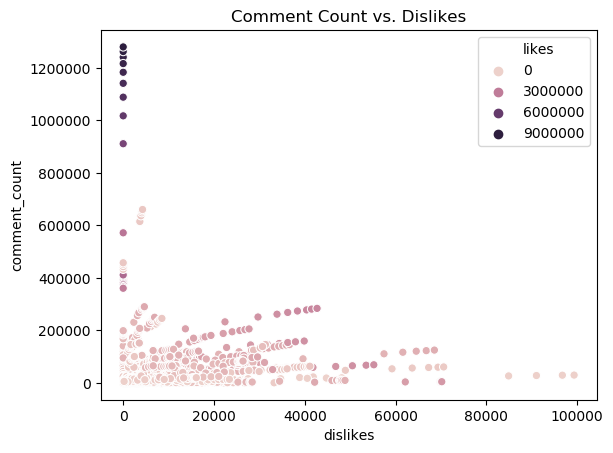

In [105]:
sns.scatterplot(data = us_gaming, x = us_gamingvlog.dislikes, y = us_gaming.comment_count, hue = us_gaming.likes)
plt.title("Comment Count vs. Dislikes")
plt.show()

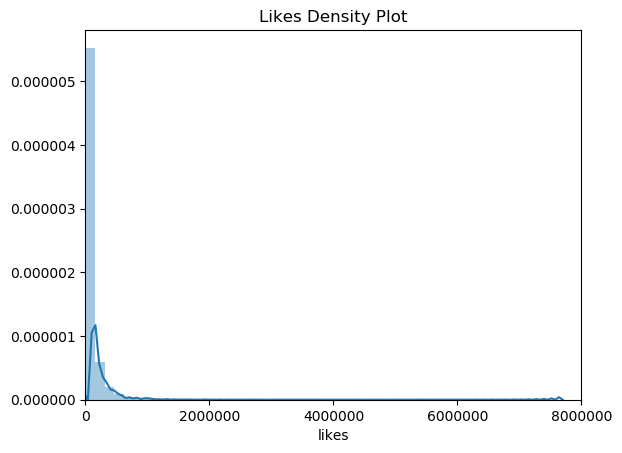

In [111]:
fig, ax = plt.subplots()

sns.distplot(us_gaming.likes, ax = ax)
plt.title("Likes Density Plot")
ax.set_xlim(0, 8000000)
ax.set_xticks([0, 2000000, 4000000, 6000000, 8000000])
plt.show()

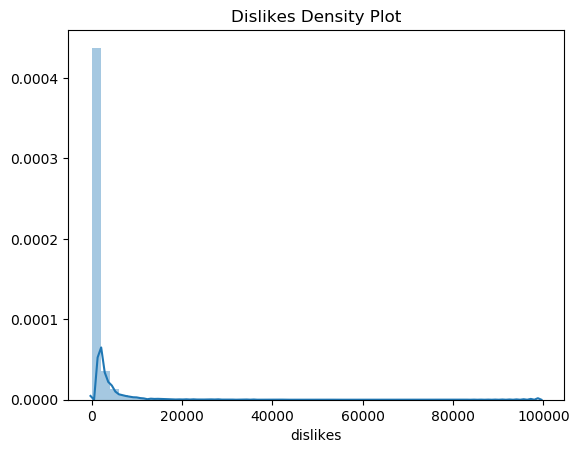

In [107]:
sns.distplot(us_gaming.dislikes)
plt.title("Dislikes Density Plot")
plt.show()

faze is a popular, legacy gaming brand at this point. Below the faze gaming organization 100t is charted as well, 100t is new gaming brand, although already find themselves very successful on YouTube. Looking at the comparison, faze, particularly prior to 2022, is the much stronger brand on YouTube, Perhaps when working out deals or collaborations with gaming brand with our creators, it would be more lucrative to attach our creators to faze's brand rather than 100t. 

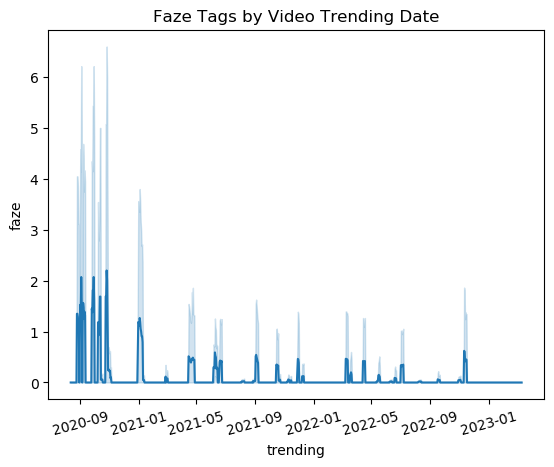

In [23]:
sns.lineplot(x = us_gaming['trending'], y = tag_df['faze'])
plt.xticks(rotation = 15)
plt.title("Faze Tags by Video Trending Date")
plt.show()

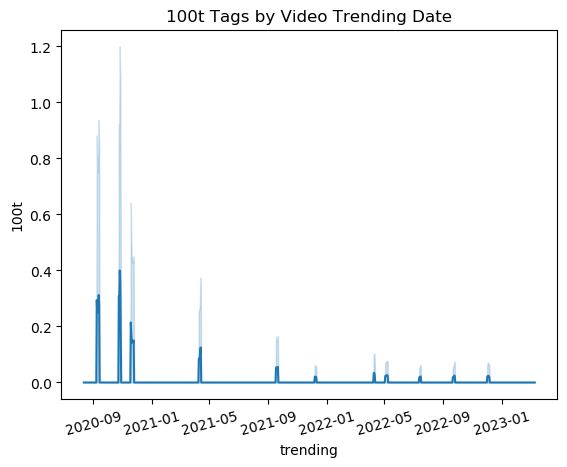

In [24]:
sns.lineplot(x = us_gaming['trending'], y = tag_df['100t'])
plt.xticks(rotation = 15)
plt.title("100t Tags by Video Trending Date")
plt.show()

Below the recently developed game Valorant is compared to Mario, one of the most popular games in existence. Mario games are more likely to trend on any given day as the time series is much more dense, but the peaks of Valorant are slightly higher. Both of these games could viably be a valuable addition to a creator's video title. 

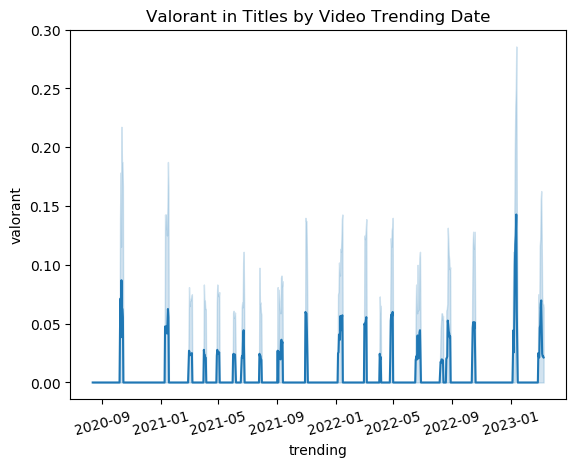

In [25]:
sns.lineplot(x = us_gaming['trending'], y = title_df['valorant'])
plt.xticks(rotation = 15)
plt.title("Valorant in Titles by Video Trending Date")
plt.show()

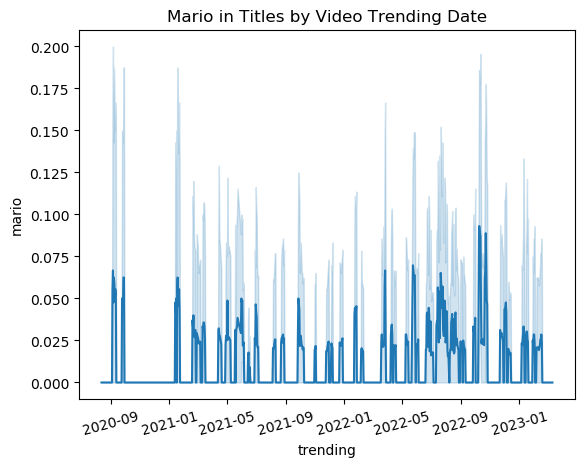

In [27]:
sns.lineplot(x = us_gaming['trending'], y = title_df['mario'])
plt.xticks(rotation = 15)
plt.title("Mario in Titles by Video Trending Date")
plt.show()